In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
from spectral_connectivity import Multitaper
from spectral_connectivity import Connectivity
from core_functions.simulated_data import simdata_settings, simulate
from core_functions.core import em_B, get_theoretical_psd_COM, B_mag_phase


In [2]:
# Simulate Model
T = 30000
blnSimS = False

fs, k, n, M, osc_freqs, rhos, var_state_nois, var_obs_noi, A, Q, R, Btrue, Z, X0, S0 = simdata_settings()

ta = np.arange(T)/fs
x_dim = k*2

if blnSimS:
    s=None
else:     
    s = np.zeros(T,dtype=int)
    s[ta>80]=1
    s[ta>200]=2

y, s, x = simulate(A, Btrue, Q, R, Z, X0, S0, T, s=s)


In [3]:
# # FOR TESTING
# import json
# import os.path as op

# with open(f"{op.expanduser('~')}/.config/sso_config.json", "r") as f:
#     config = json.load(f)
# basepath = config['basepath']
# loadpath = op.join(basepath, 'simdata', 'y_sim.mat')

# y = scipy.io.loadmat(loadpath)['y'].T
# B0 = Btrue
# X0 = 0.1*np.ones(x_dim)

(100.0, 105.0)

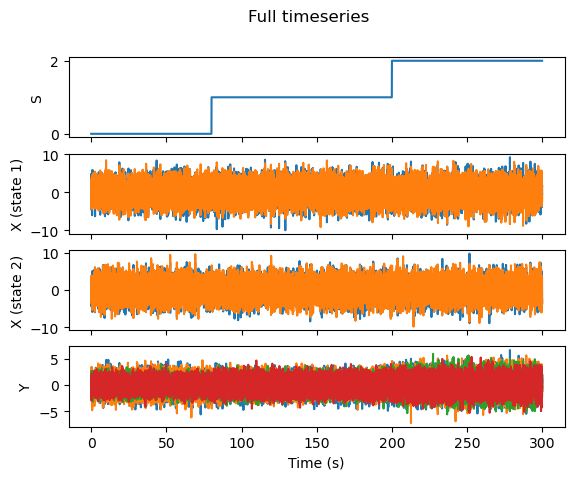

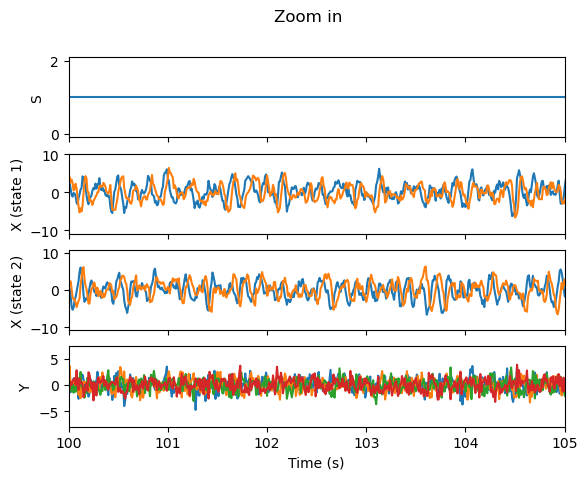

In [4]:
# Plot the simulated data
[fig,axs] = plt.subplots(2+k,1,sharex=True)
axs[0].plot(ta, s)
axs[0].set_ylabel('S')
for i in range(k):
    axs[1+i].plot(ta, x[:,2*i:2*i+2])
    axs[1+i].set_ylabel(f'X (state {i+1})')
axs[k+1].plot(ta, y)
axs[k+1].set_ylabel('Y')
axs[k+1].set_xlabel('Time (s)')
fig.suptitle('Full timeseries')

[fig,axs] = plt.subplots(2+k,1,sharex=True)
axs[0].plot(ta, s)
axs[0].set_ylabel('S')
for i in range(k):
    axs[1+i].plot(ta, x[:,2*i:2*i+2])
    axs[1+i].set_ylabel(f'X (state {i+1})')
axs[k+1].plot(ta, y)
axs[k+1].set_ylabel('Y')
axs[k+1].set_xlabel('Time (s)')
fig.suptitle('Zoom in')
axs[0].set_xlim([100,105])


In [5]:
# Pretend we don't know B and fit it
tol = 1e-3 # Tolerance
max_iter = 50 # Max iterations

B0 = np.random.uniform(0,0.1,size=[n,x_dim,M])

mle_B, X_RTS, SW, Q_func, itr = em_B(y, tol, max_iter, A, B0, Q, R, Z, X0)

iter: 0, Q-function: -157865.79916634152
iter: 1, Q-function: -139064.09424808642
iter: 2, Q-function: -132638.33330180743
iter: 3, Q-function: -129259.67046535778
iter: 4, Q-function: -126155.5731371216
iter: 5, Q-function: -124262.39705204814
iter: 6, Q-function: -123173.59161299943
iter: 7, Q-function: -122446.11645096331
iter: 8, Q-function: -121932.6447639883
iter: 9, Q-function: -121559.40086348876
iter: 10, Q-function: -121282.28600943633
iter: 11, Q-function: -121072.92753545326
iter: 12, Q-function: -120912.33482879744


Text(0.5, 0, 'Time (s)')

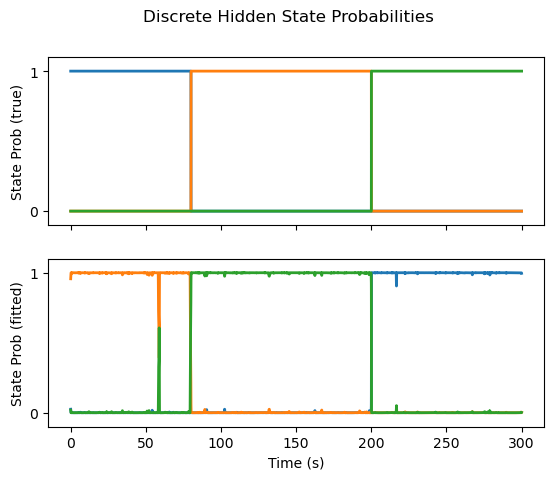

In [6]:
# plot discrete hidden state probabilities

SW_true = np.vstack([s==i for i in range(M)]).T

[fig, axs] = plt.subplots(2,1,sharex=True,sharey=True)
axs[0].plot(ta,SW_true[:,:],linewidth=2)
axs[0].set_ylabel('State Prob (true)')
axs[0].set_yticks([0, 1])
axs[0].set_ylim([-0.1, 1.1])
axs[1].plot(ta,SW[:,:,itr],linewidth=2)
axs[1].set_ylabel('State Prob (fitted)')
axs[1].set_yticks([0, 1])
axs[1].set_ylim([-0.1, 1.1])
fig.suptitle('Discrete Hidden State Probabilities')
axs[-1].set_xlabel('Time (s)')

In [7]:
# Check B
np.set_printoptions(precision=2,suppress=True)
for m in range(M):
    print(f'True B_{m}: \n{Btrue[:,:,m]}')
    print(f'Fitted B_{m}: \n{mle_B[:,:,m,itr]}')


True B_0: 
[[0.4 0.  0.  0. ]
 [0.  0.  0.4 0. ]
 [0.  0.  0.  0. ]
 [0.  0.  0.  0. ]]
Fitted B_0: 
[[-0.11  0.3   0.35  0.01]
 [ 0.11 -0.29 -0.35 -0.01]
 [-0.11  0.29  0.35  0.01]
 [ 0.29 -0.08  0.18  0.2 ]]
True B_1: 
[[ 0.3   0.    0.    0.  ]
 [ 0.    0.3   0.    0.  ]
 [ 0.    0.    0.25  0.  ]
 [ 0.    0.    0.   -0.25]]
Fitted B_1: 
[[ 0.06  0.22  0.31  0.02]
 [ 0.22  0.22 -0.22  0.12]
 [-0.   -0.01  0.01  0.01]
 [-0.01 -0.   -0.01 -0.01]]
True B_2: 
[[ 0.5  0.   0.   0. ]
 [-0.5  0.   0.   0. ]
 [ 0.5  0.   0.   0. ]
 [ 0.   0.   0.4  0. ]]
Fitted B_2: 
[[ 0.11  0.06  0.27  0.07]
 [-0.05  0.1  -0.06  0.27]
 [ 0.2   0.06 -0.1  -0.01]
 [ 0.06 -0.21 -0.    0.1 ]]


Text(0, 0.5, 'Fitted')

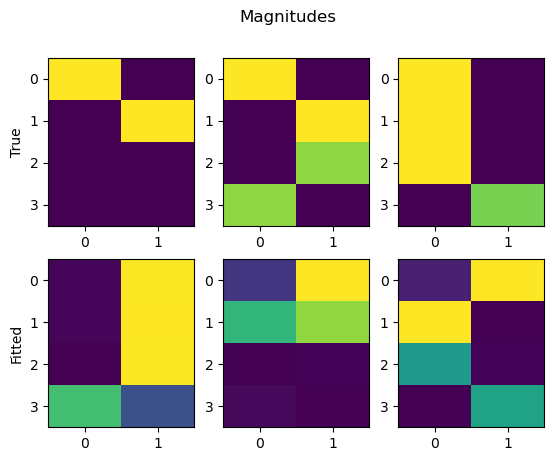

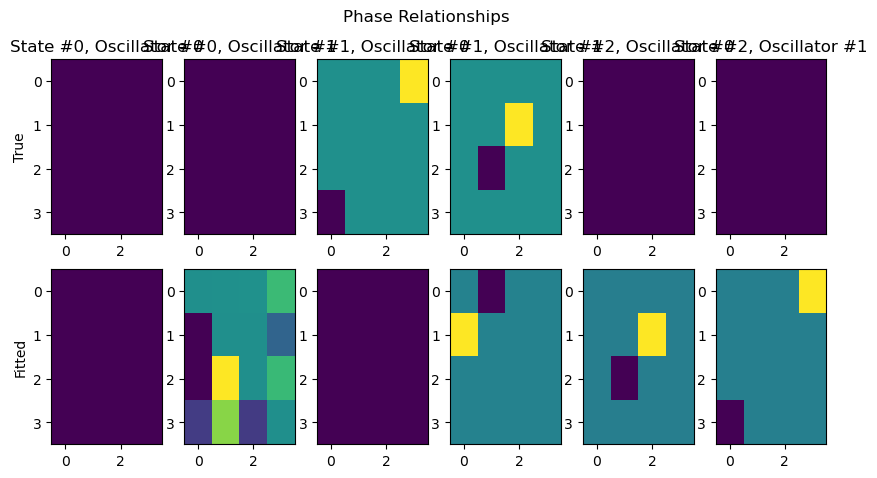

In [8]:
# Plot Magnitudes of B
mag_true, phase_true = B_mag_phase(Btrue)
mag_fit, phase_fit = B_mag_phase(mle_B[:,:,:,itr])

# plot magnitudes
[fig,axs] = plt.subplots(2,M)
for m in range(M):    
    axs[0,m].imshow(mag_true[:,:,m],aspect='auto')
    axs[1,m].imshow(mag_fit[:,:,m],aspect='auto')
axs[1,0].set_ylabel('Fitted')
axs[0,0].set_ylabel('True')
fig.suptitle('Magnitudes')

    
# plot phase relationships
[fig,axs] = plt.subplots(2,M*k,figsize=[10,5])
for m in range(M):    
    for i in range(k):
        axs[0,k*m+i].imshow(phase_true[:,:,i,m],aspect='auto')
        axs[1,k*m+i].imshow(phase_fit[:,:,i,m],aspect='auto')
        axs[0,k*m+i].set_title(f'State #{m}, Oscillator #{i}')
fig.suptitle('Phase Relationships')
axs[0,0].set_ylabel('True')
axs[1,0].set_ylabel('Fitted')
   


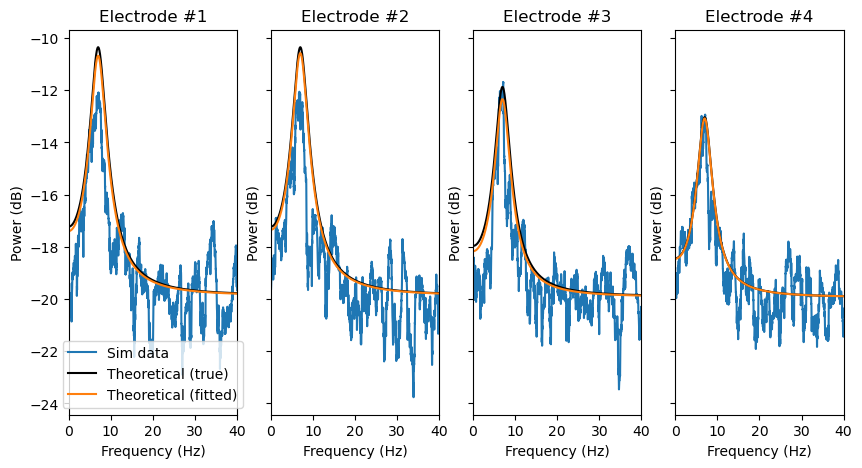

In [9]:
# plot empirical and theoretical spectra

TW=3000
ntapers = 20

m = Multitaper(y,
                sampling_frequency=fs,
                time_halfbandwidth_product=TW,
                n_tapers=20,
                start_time=ta[0])
c = Connectivity(fourier_coefficients=m.fft(),
                frequencies=m.frequencies,
                time=m.time)

Stheo, Stheo_per_state = get_theoretical_psd_COM(c.frequencies,
                                                fs,
                                                osc_freqs,
                                                rhos,
                                                var_state_nois,
                                                var_obs_noi,
                                                Btrue,
                                                s)

Stheo_fit, Stheo_per_state_fit = get_theoretical_psd_COM(c.frequencies,
                                                fs,
                                                osc_freqs,
                                                rhos,
                                                var_state_nois,
                                                var_obs_noi,
                                                mle_B[:,:,:,itr],
                                                SW[:,:,itr])

[fig, axs] = plt.subplots(1,n,sharex=True,sharey=True,figsize=[10,5])
for i in range(n):
    axs[i].plot(c.frequencies, 10*np.log10(c.power().squeeze()[:,i]),label='Sim data')
    axs[i].plot(c.frequencies,10*np.log10(Stheo[:,i]),color='k',label='Theoretical (true)')
    axs[i].plot(c.frequencies,10*np.log10(Stheo_fit[:,i]),label='Theoretical (fitted)')
    axs[i].set_title(f'Electrode #{i+1}')
    axs[i].set_ylabel('Power (dB)')
    axs[i].set_xlabel('Frequency (Hz)')
axs[0].set_xlim(0,40)
axs[0].legend(loc='lower center')
